In [1]:
!pip install opencv-python-headless

In [2]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import os

2024-05-31 20:49:40.878754: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def read_image(file_path):
    rgb_image = cv2.imread(file_path)
    return rgb_image

In [4]:
X = []
y = []

df = pd.read_csv('gtzan_features_3_sec.csv')
dataset_path = "gtzan"
for index, row in tqdm(df.iterrows()):
    try:
        file_path = os.path.join(dataset_path, row["label"] + "/" + row["filename"].replace(".", "_", 2).split(".")[0] + ".jpg").replace("\\", "/")
        image_rgb_matrix = read_image(file_path)
        image_rgb_matrix = image_rgb_matrix.astype('float32') / 255.0 # NORMALIZE RGB VALUES IN [0,1]
        label = row["label"]
        X.append(image_rgb_matrix)
        y.append(label)
    except:
        print("File error")
X = np.array(X)
y = np.array(y)
print(X.shape)
print(y.shape)

5503it [00:07, 590.26it/s][ WARN:0@11.832] global loadsave.cpp:248 findDecoder imread_('gtzan/jazz/jazz_00054_0.jpg'): can't open/read file: check file path/integrity
[ WARN:0@11.833] global loadsave.cpp:248 findDecoder imread_('gtzan/jazz/jazz_00054_1.jpg'): can't open/read file: check file path/integrity
[ WARN:0@11.833] global loadsave.cpp:248 findDecoder imread_('gtzan/jazz/jazz_00054_2.jpg'): can't open/read file: check file path/integrity
[ WARN:0@11.834] global loadsave.cpp:248 findDecoder imread_('gtzan/jazz/jazz_00054_3.jpg'): can't open/read file: check file path/integrity
[ WARN:0@11.834] global loadsave.cpp:248 findDecoder imread_('gtzan/jazz/jazz_00054_4.jpg'): can't open/read file: check file path/integrity
[ WARN:0@11.834] global loadsave.cpp:248 findDecoder imread_('gtzan/jazz/jazz_00054_5.jpg'): can't open/read file: check file path/integrity
[ WARN:0@11.835] global loadsave.cpp:248 findDecoder imread_('gtzan/jazz/jazz_00054_6.jpg'): can't open/read file: check file pa

File error
File error
File error
File error
File error
File error
File error
File error
File error
File error


9990it [00:13, 735.88it/s]


(9980, 130, 128, 3)
(9980,)


In [5]:
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(y)
len(labelencoder.classes_)

# To see the mapping, you can create a dictionary using the classes_ attribute
label_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))

print("Label Mapping:", label_mapping)

Label Mapping: {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(7984, 130, 128, 3)
(7984,)
(1996, 130, 128, 3)
(1996,)


In [7]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(130, 128, 3))
for layer in base_model.layers:
    layer.trainable = True

model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(10, activation='softmax')
    ])
optimizer = Adam(learning_rate=0.00001)
model.summary()
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
model.save('gtzan_full_resnet.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 24,114,826
Trainable params: 24,061,706
Non-trainable params: 53,120
_______________________________________

2024-05-31 20:50:02.839596: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1594245120 exceeds 10% of free system memory.


250/250 [==============================] - 750s 3s/step - loss: 2.1289 - accuracy: 0.2518 - val_loss: 3.1114 - val_accuracy: 0.0992
Epoch 2/10
250/250 [==============================] - 718s 3s/step - loss: 1.5423 - accuracy: 0.4560 - val_loss: 4.6863 - val_accuracy: 0.1293
Epoch 3/10
250/250 [==============================] - 717s 3s/step - loss: 1.2217 - accuracy: 0.5802 - val_loss: 3.2800 - val_accuracy: 0.1308
Epoch 4/10
250/250 [==============================] - 719s 3s/step - loss: 0.9707 - accuracy: 0.6743 - val_loss: 1.9733 - val_accuracy: 0.2826
Epoch 5/10
250/250 [==============================] - 713s 3s/step - loss: 0.7649 - accuracy: 0.7548 - val_loss: 1.3962 - val_accuracy: 0.5195
Epoch 6/10
250/250 [==============================] - 711s 3s/step - loss: 0.5746 - accuracy: 0.8279 - val_loss: 1.1900 - val_accuracy: 0.5887
Epoch 7/10
250/250 [==============================] - 731s 3s/step - loss: 0.4369 - accuracy: 0.8825 - val_loss: 1.1872 - val_accuracy: 0.6017
Epoch 8/10

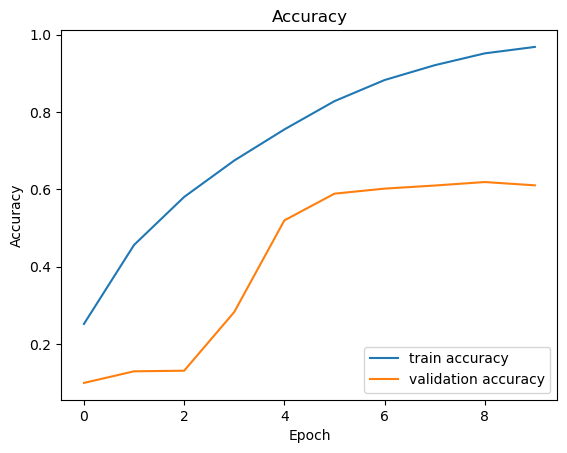

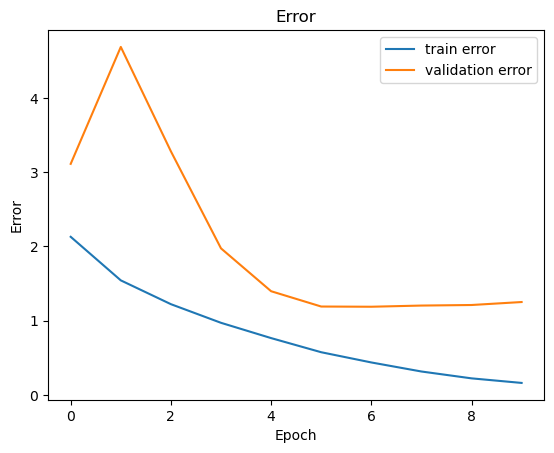

In [8]:
from matplotlib import pyplot as plt
plt.figure(1)
plt.plot(history.history["accuracy"], label="train accuracy")
plt.plot(history.history["val_accuracy"], label="validation accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(loc="lower right")
plt.title("Accuracy")
plt.savefig("gtzan_full_rn50_acc.png")
plt.show()

plt.figure(2)
plt.plot(history.history["loss"], label="train error")
plt.plot(history.history["val_loss"], label="validation error")
plt.ylabel("Error")
plt.xlabel("Epoch")
plt.legend(loc="upper right")
plt.title("Error")
plt.savefig("gtzan_full_rn50_loss.png")
plt.show()